In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from os import listdir
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import cv2
import tqdm

In [25]:
class HiddenPatchAnalysis:

    def __init__(self, img_path, IMG_SIZE, STRIDE, PATCH_SIZE, model):
        self.IMG_SIZE = IMG_SIZE
        self.STRIDE = STRIDE
        self.PATCH_SIZE = PATCH_SIZE
        self.original = cv2.cvtColor(cv2.resize(cv2.imread(img_path), (self.IMG_SIZE, self.IMG_SIZE)),
                                     cv2.COLOR_RGB2BGR)
        self.model = model
        self.mask = None
        self.labels = None
        self.colors = None
        
    def hide_patch(self, patch_color = [150, 150, 150], patch_position = None):
        assert self.PATCH_SIZE%2==1, 'patch_size must be an odd number'
        hidden = self.original.copy()
        if patch_position is None:
            px = np.random.choice(self.IMG_SIZE)
            py = np.random.choice(self.IMG_SIZE)
        else:
            px = patch_position[0]
            py = patch_position[1]
        for i in range(px - self.PATCH_SIZE//2, px + self.PATCH_SIZE//2 + 1):
            for j in range(py - self.PATCH_SIZE//2, py + self.PATCH_SIZE//2 + 1):
                if i>=0 and i<self.IMG_SIZE and j>=0 and j<self.IMG_SIZE:
                    hidden[i, j] = patch_color
        return hidden, [px, py]

    def generate_hidden_images(self):
        hidden_images = {}
        for x in tqdm.tqdm(range(0, IMG_SIZE, self.STRIDE)):
            for y in range(0, IMG_SIZE, self.STRIDE):
                hidden, _ = self.hide_patch([150, 150, 150], patch_position = [x, y])
                hidden_images[(x, y)] = hidden
        return hidden_images
    
    def make_predictions(self, hidden_images):
        n = len(hidden_images)
        flatten = []
        for k in hidden_images.keys():
            flatten.append(hidden_images[k])
        flatten.append(self.original) # the last one is the original one
        flatten = np.array(flatten)
        to_recognize = tf.convert_to_tensor(flatten)
        res_hidden = self.model.predict(to_recognize, steps = n, verbose = 1)
        preds = decode_predictions(res_hidden, top=5)
        return preds
    
    def compute_plot_from_predictions(self):
        print('Generating hidden images')
        hidden_images = self.generate_hidden_images()
        print('Feeding the model')
        preds = self.make_predictions(hidden_images)
        print('Results collected')
        res_dict = {}
        k = 0
        for i in range(0, self.IMG_SIZE, self.STRIDE):
            for j in range(0, self.IMG_SIZE, self.STRIDE):
                res_dict[(i, j)] = preds[k]
                k+=1
        res_dict[(-1, -1)] = preds[-1]
        self.labels = []
        for i in res_dict.keys():
            if res_dict[i][0][1] not in self.labels:
                self.labels.append(res_dict[i][0][1])
        self.colors = 255 * np.random.rand(len(self.labels), 3)
        self.mask = self.original * 0
        for px in range(0, IMG_SIZE, STRIDE):
            for py in range(0, IMG_SIZE, STRIDE):
                c = self.colors[self.labels.index( res_dict[(px, py)][0][1],0)]
                for i in range(px - PATCH_SIZE//2, px + PATCH_SIZE//2 + 1):
                    for j in range(py - PATCH_SIZE//2, py + PATCH_SIZE//2 + 1):
                        if i>=0 and i<IMG_SIZE and j>=0 and j<IMG_SIZE:
                            self.mask[i, j] = c
                            
    def plot_mask(self):
        plt.figure(figsize = (15, 10))
        plt.subplot(221)
        plt.imshow(self.original)
        plt.subplot(222)
        plt.imshow(self.mask)
        
    def plot_legend(self):
        for i in range(len(self.labels)):
            plt.figure(figsize = (3, 3))
            blank_image = np.zeros((2, 5, 3), np.uint8)
            for x in range(2):
                for y in range(5):
                    blank_image[x, y, :] = self.colors[i]
            plt.imshow(blank_image)
            plt.title(self.labels[i])

In [16]:
IMG_SIZE = 224
STRIDE = 55
PATCH_SIZE = 55
model = VGG16(include_top=True, weights='imagenet', input_tensor=None,
                               input_shape=None, pooling=None, classes=1000)
img_path = './images/cat.jpg'

In [26]:
HPA = HiddenPatchAnalysis(img_path, IMG_SIZE, STRIDE, PATCH_SIZE, model)

In [27]:
HPA.compute_plot_from_predictions()

100%|██████████| 5/5 [00:00<00:00, 60.25it/s]

Generating hidden images
Feeding the model


25/25 [==============================] - 331s 13s/step
Results collected


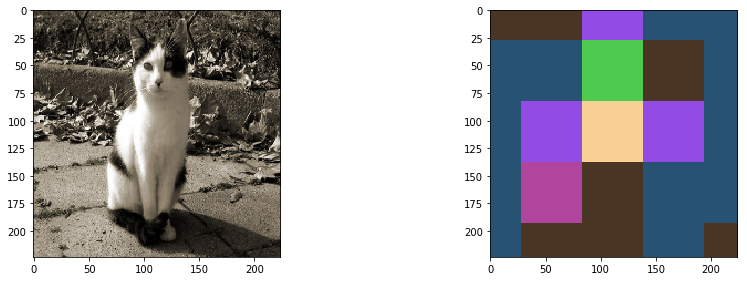

In [28]:
HPA.plot_mask()

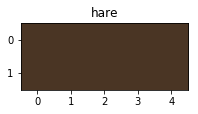

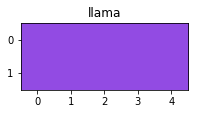

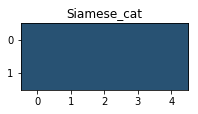

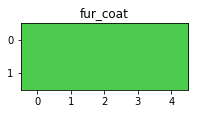

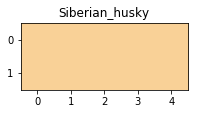

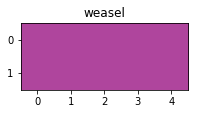

In [29]:
HPA.plot_legend()